# Tutorial for classification

In this tutorial, we compare the prediction sets estimated by the conformal methods implemented in MAPIE on a toy two-dimensional dataset.

Throughout this tutorial, we will answer the following questions:

- How does the number of classes in the prediction sets vary according to the significance level ?

- Is the chosen conformal method well calibrated ? 

- What are the pros and cons of the conformal methods included in MAPIE ?

## 1. Conformal Prediction method using the softmax score of the true label

We will use MAPIE to estimate a prediction set of several classes such that the probability that the true label
of a new test point is included in the prediction set is always higher than the target confidence level :
$P(Y \in C) \geq 1 - \alpha$.
We start by using the softmax score output by the base classifier as the conformity score on a toy two-dimensional dataset.
We estimate the prediction sets as follows :

* First we generate a dataset with train, calibration and test, the model is fitted on the training set.
* We set the conformal score $S_i = \hat{f}(X_{i})_{y_i}$ the softmax output of the true class for each sample in the calibration set.
* Then we define $\hat{q}$ as being the $(n + 1) (\alpha) / n$ previous quantile of $S_{1}, ..., S_{n}$
(this is essentially the quantile $\alpha$, but with a small sample correction). 
* Finally, for a new test data point (where $X_{n + 1}$ is known but $Y_{n + 1}$ is not), create a prediction set
$C(X_{n+1}) = \{y: \hat{f}(X_{n+1})_{y} > \hat{q}\}$ which includes all the classes with a sufficiently high softmax output.

We use a two-dimensional toy dataset with three labels. The distribution of the data is a bivariate normal with diagonal covariance matrices for each label. 

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
centers = [(0, 3.5), (-2, 0), (2, 0)]
covs = [np.eye(2), np.eye(2)*2, np.diag([5, 1])]
x_min, x_max, y_min, y_max, step = -6, 8, -6, 8, 0.1
n_samples = 1000
n_classes = 3
np.random.seed(42)
X = np.vstack([
    np.random.multivariate_normal(center, cov, n_samples)
    for center, cov in zip(centers, covs)
])
y = np.hstack([np.full(n_samples, i) for i in range(n_classes)])
X_train_cal, X_test, y_train_cal, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_cal, y_train, y_cal = train_test_split(X_train_cal, y_train_cal, test_size=0.25)

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, step), np.arange(x_min, x_max, step)
)
X_test_mesh = np.stack([xx.ravel(), yy.ravel()], axis=1)

In [2]:
X

array([[ 0.49671415,  3.3617357 ],
       [ 0.64768854,  5.02302986],
       [-0.23415337,  3.26586304],
       ...,
       [ 3.93090785,  0.17146932],
       [ 4.57739951, -1.21740379],
       [ 3.04636895, -1.17028071]])

Let’s see our training data.

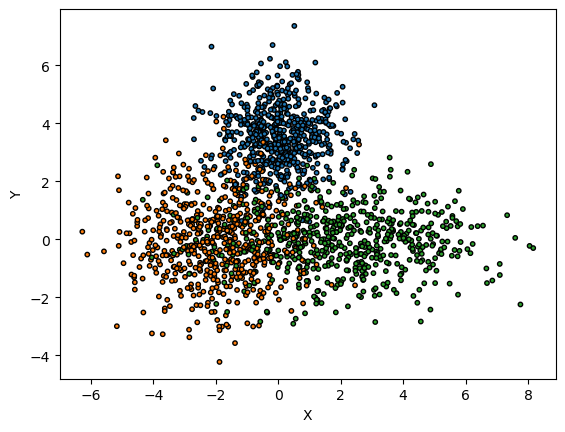

In [3]:
import matplotlib.pyplot as plt
colors = {0: "#1f77b4", 1: "#ff7f0e", 2:  "#2ca02c", 3: "#d62728"}
y_train_col = list(map(colors.get, y_train))
fig = plt.figure()
plt.scatter(
    X_train[:, 0],
    X_train[:, 1],
    color=y_train_col,
    marker='o',
    s=10,
    edgecolor='k'
)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

We fit our training data with a Gaussian Naive Base estimator. And then we apply MAPIE in the calibration data with the method ``score`` to the estimator indicating that it has already been fitted with `cv="prefit"`.
We then estimate the prediction sets with differents alpha values with a
``fit`` and ``predict`` process. 

In [5]:
from sklearn.naive_bayes import GaussianNB
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score, classification_mean_width_score
%load_ext autoreload
%autoreload 2


In [6]:
clf = GaussianNB()
mapie_score = MapieClassifier(estimator=clf, cv=10, method="lac", random_state=42)
mapie_score.fit(X_train, y_train)
alpha = [0.2, 0.1, 0.05]
y_pred_score, y_ps_score = mapie_score.predict(X_test_mesh, alpha=alpha)

# TEST

In [8]:
clf = GaussianNB()

In [9]:
mapie_score = MapieClassifier(estimator=clf, cv=10, method="lac", random_state=42)

# FIN TEST

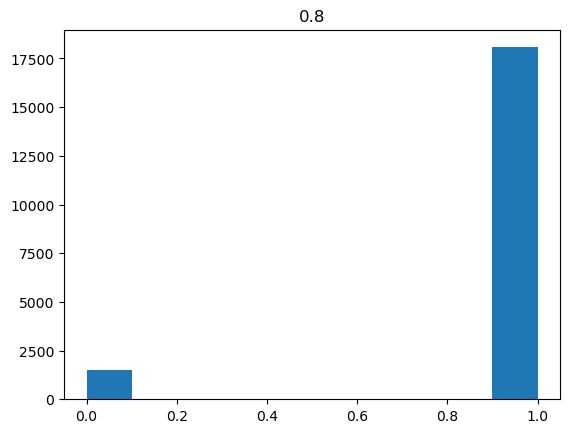

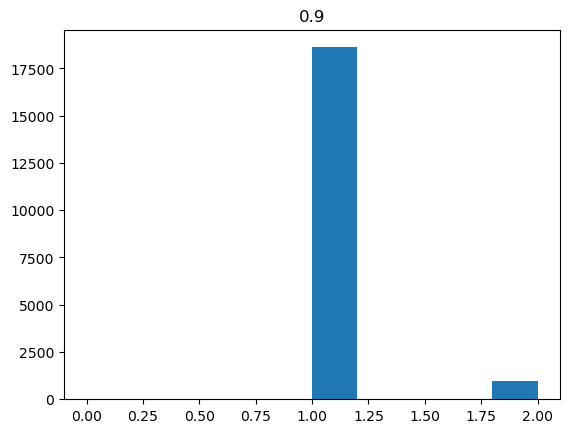

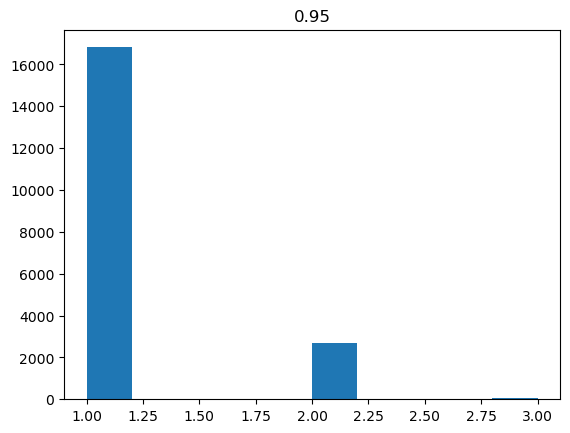

In [10]:
for i in range(len(alpha)):
    y_pss = y_ps_score[:, :, i]
    sizes = np.sum(y_pss, axis=1)
    plt.hist(sizes)
    plt.title(1 - alpha[i])
    plt.show()

* ``y_pred_score``: represents the prediction in the test set by the base estimator.
* ``y_ps_score``: the prediction sets estimated by MAPIE with the "lac" method.

In [ ]:
def plot_scores(n, alphas, scores, quantiles):
    colors = {0:"#1f77b4", 1:"#ff7f0e", 2:"#2ca02c"}
    fig = plt.figure(figsize=(7, 5))
    plt.hist(scores, bins="auto")
    i=0
    for i, quantile in enumerate(quantiles):
         plt.vlines(
             x = quantile,
             ymin=0,
             ymax=400,
             color=colors[i],
             ls= "dashed",
             label=f"alpha = {alphas[i]}"
         )
    plt.title("Distribution of scores")
    plt.legend()
    plt.xlabel("Scores")
    plt.ylabel("Count")
    plt.show()

Let’s see the distribution of the scores with the calculated quantiles.

In [ ]:
scores = mapie_score.conformity_scores_
n = len(mapie_score.conformity_scores_)
quantiles = mapie_score.quantiles_
plot_scores(n, alpha, scores, quantiles)

The estimated quantile increases with alpha. A high value of alpha can potentially lead to a high quantile which would not necessarily be reached by any class in uncertain areas, resulting in null regions.

We will now visualize the differences between the prediction sets of the different values of alpha.

In [ ]:
def plot_results(alphas, X, y_pred, y_ps):
    tab10 = plt.cm.get_cmap('Purples', 4)
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2:  "#2ca02c", 3: "#d62728"}
    y_pred_col = list(map(colors.get, y_pred))
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10, 10))
    axs = {0: ax1, 1: ax2, 2:  ax3, 3: ax4}
    axs[0].scatter(
        X[:, 0],
        X[:, 1],
        color=y_pred_col,
        marker='.',
        s=10,
        alpha=0.4
    )
    axs[0].set_title("Predicted labels")
    for i, alpha in enumerate(alphas):
        y_pi_sums = y_ps[:, :, i].sum(axis=1)
        num_labels = axs[i+1].scatter(
            X[:, 0],
            X[:, 1],
            c=y_pi_sums,
            marker='.',
            s=10,
            alpha=1,
            cmap=tab10,
            vmin=0,
            vmax=3
        )
        cbar = plt.colorbar(num_labels, ax=axs[i+1])
        axs[i+1].set_title(f"Number of labels for alpha={alpha}")
    plt.show()

In [ ]:
plot_results(alpha, X_test_mesh, y_pred_score, y_ps_score)

When the class coverage is not large enough, the prediction sets can be empty when the model is uncertain at the border between two classes. The null region disappears for larger class coverages but ambiguous classification regions arise with several labels included in the prediction sets highlighting the uncertain behaviour of the base classifier.

Let’s now study the effective coverage and the mean prediction set widths as function of the $1-\alpha$ target coverage. To this aim, we use once again the `.predict()` method of MAPIE to estimate predictions sets on a large number of $\alpha$ values.

In [ ]:
alpha2 = np.arange(0.02, 0.98, 0.02)
_, y_ps_score2 = mapie_score.predict(X_test, alpha=alpha2)
coverages_score = [
    classification_coverage_score(y_test, y_ps_score2[:, :, i])
    for i, _ in enumerate(alpha2)
]
widths_score = [
    classification_mean_width_score(y_ps_score2[:, :, i])
    for i, _ in enumerate(alpha2)
]

In [ ]:
def plot_coverages_widths(alpha, coverage, width, method):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].scatter(1 - alpha, coverage, label=method)
    axs[0].set_xlabel("1 - alpha")
    axs[0].set_ylabel("Coverage score")
    axs[0].plot([0, 1], [0, 1], label="x=y", color="black")
    axs[0].legend()
    axs[1].scatter(1 - alpha, width, label=method)
    axs[1].set_xlabel("1 - alpha")
    axs[1].set_ylabel("Average size of prediction sets")
    axs[1].legend()
    plt.show()

In [ ]:
plot_coverages_widths(alpha2, coverages_score, widths_score, "lac")

## 2. Conformal Prediction method using the cumulative softmax score

We saw in the previous section that the "lac" method is well calibrated by providing accurate coverage levels. However, it tends to give null prediction sets for uncertain regions, especially when the $\alpha$ value is high. MAPIE includes another method, called Adaptive Prediction Set (APS), whose conformity score is the cumulated score of the softmax output until the true label is reached (see the theoretical description for more details). We will see in this Section that this method no longer estimates null prediction sets but by giving slightly bigger prediction sets. 

Let's visualize the prediction sets obtained with the APS method on the test set after fitting MAPIE on the calibration set.

In [ ]:
mapie_aps = MapieClassifier(estimator=clf, cv="prefit", method="aps")
mapie_aps.fit(X_cal, y_cal)
alpha = [0.2, 0.1, 0.05]
y_pred_aps, y_ps_aps = mapie_aps.predict(X_test_mesh, alpha=alpha, include_last_label=True)

In [ ]:
plot_results(alpha, X_test_mesh, y_pred_aps, y_ps_aps)

One can notice that the uncertain regions are emphasized by wider boundaries, but without null prediction sets with respect to the first "lac" method. 

In [ ]:
_, y_ps_aps2 = mapie_aps.predict(X_test, alpha=alpha2, include_last_label="randomized")
coverages_aps = [
    classification_coverage_score(y_test, y_ps_aps2[:, :, i])
    for i, _ in enumerate(alpha2)
]
widths_aps = [
    classification_mean_width_score(y_ps_aps2[:, :, i])
    for i, _ in enumerate(alpha2)
]

In [ ]:
plot_coverages_widths(alpha2, coverages_aps, widths_aps, "lac")

This method also gives accurate calibration plots, meaning that the effective coverage level is always very close to the target coverage, sometimes at the expense of slightly bigger prediction sets. 